In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import qldpc
from qldpc import abstract, codes
import cirq
import stimcirq
import stim
import numpy as np

import sinter
import pymatching

import matplotlib.pyplot as plt

In [3]:
#noise model 
class MyNoiseModel(cirq.NoiseModel):
    def __init__(self, single_qubit_error = None, two_qubit_error = None) -> None:
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        
    def noisy_operation(self, op: cirq.Operation) -> cirq.OP_TREE:
        if isinstance(op.gate, cirq.PauliMeasurementGate):
            return op
        if len(op.qubits) == 1:
            return [op, cirq.depolarize(self.single_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        elif len(op.qubits) == 2:
            return [op, cirq.depolarize(self.two_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        else: 
            raise ValueError("This circuit should be decomposed before implementing a Noise Model")

In [4]:
def get_toric_code(distance) -> codes.CSSCode:
    """Rotated toric code as a quantum Tanner code."""
    group = abstract.Group.product(abstract.CyclicGroup(distance), repeat=2)
    shift_x, shift_y = group.generators
    subset_a = [shift_x, ~shift_x]
    subset_b = [shift_y, ~shift_y]
    subcode = codes.BitCode.repetition(2)
    return codes.QTCode(subset_a, subset_b, subcode)

In [290]:
class SurfaceCode(codes.CSSCode): 
    def __init__(self, distance):
        assert distance == 3
        self.distance = distance
        code_x = np.zeros((4,9), dtype=int)
        code_z = np.zeros((4,9), dtype=int)
        
        code_x = np.zeros((4, 9), dtype=int)
        code_x[0, 3] = 1
        code_x[0, 6] = 1
        code_x[1, 0] = 1
        code_x[1, 1] = 1
        code_x[1, 3] = 1
        code_x[1, 4] = 1
        code_x[2, 4] = 1
        code_x[2, 5] = 1
        code_x[2, 7] = 1
        code_x[2, 8] = 1
        code_x[3, 2] = 1
        code_x[3, 5] = 1

        code_z = np.zeros((4, 9), dtype=int)
        code_z[0, 0] = 1
        code_z[0, 1] = 1
        code_z[1, 3] = 1
        code_z[1, 4] = 1
        code_z[1, 6] = 1
        code_z[1, 7] = 1
        code_z[2, 1] = 1
        code_z[2, 2] = 1
        code_z[2, 4] = 1
        code_z[2, 5] = 1
        code_z[3, 7] = 1
        code_z[3, 8] = 1
 
        codes.CSSCode.__init__(self, code_x, code_z)

In [327]:
class SyndromeExtractionCircuit:
    def __init__(self, qldpc_code, error_type, single_qubit_error = 0.01, two_qubit_error = 0.01, rounds = 3) -> None:
        self.code = qldpc_code
        self.rounds = rounds
        self.error_type = error_type
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.ancillas= self.get_ancillas()
        self.error_ancillas = self.get_error_ancillas()
        self.data_qubits = self.get_data_qubits()
        self.qubit_index = self.get_stim_qubit_index()
        self.logical_x, self.logical_z = self.get_logical_operators()
        self.cirq_circuit = self.code_to_cirq_circuit()
        self.decomposed_cirq_circuit = self.cirq_circuit.map_operations(self.decompose_extraction_gates)
        self.noisy_circuit = self.circuit_with_noise()
        self.stim_circuit = self.code_to_stim_circuit()
        

    def insert_measurements(self, circuit):
        for qubit, pauli in self.ancillas.items():
            if pauli == self.error_type:
                circuit += [cirq.measure(cirq.NamedQubit(str(qubit))), cirq.reset(cirq.NamedQubit(str(qubit)))]
        return circuit

    
    def get_stim_qubit_index(self): #see if you can factor out total_qubits to use the specific ancillas 
        qubit_index_dict = {}
        total_qubits = [ancilla for ancilla in self.ancillas.keys()] + self.data_qubits
        for index, qubit in enumerate(total_qubits):
            qubit_index_dict[qubit] = index
            
        return qubit_index_dict
        
        
    def get_error_ancillas(self):
        return [ancilla for ancilla, pauli in self.ancillas.items() if pauli == self.error_type]
    
    def get_ancillas(self): #include option to factor out whether or not you want specific ancillas
        ancillas = {}
        if self.error_type:
            for ancilla in [qubit for qubit in sorted(self.code.graph.nodes) if not qubit.is_data]:
                for neighbor in self.code.graph.successors(ancilla):
                    ancillas[ancilla] = str(self.code.graph[ancilla][neighbor][codes.Pauli]) # a bit ugly, try to clean. only works for CSS
            
        return ancillas
    
    
    def get_data_qubits(self):
        data_qubits = []
        for data_qubit in [qubit for qubit in sorted(self.code.graph.nodes) if qubit.is_data]:
            data_qubits.append(cirq.NamedQubit(str(data_qubit)))
        return data_qubits
    

    #use the nodes of the graph rather than the code
    
    
#     def code_to_cirq_circuit(self):
#         circuit = cirq.Circuit()
#         for ancilla, pauli in self.ancillas.items():

#             ## If error type is factored out, don't need this
#             string = {
#                 cirq.NamedQubit(str(neighbor)): pauli for neighbor in self.code.graph.successors(ancilla)
#                 }
#             circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
#             circuit += cirq.PauliString(string).controlled_by(cirq.NamedQubit(str(ancilla)))
#             circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
  

#         return circuit

    def code_to_cirq_circuit(self):
        circuit = cirq.Circuit()
        for ancilla, pauli in self.ancillas.items():
            if pauli == "X":
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
                circuit += [cirq.CX(cirq.NamedQubit(str(ancilla)), cirq.NamedQubit(str(neighbor)))
                           for neighbor in self.code.graph.successors(ancilla)]
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
            else:
                circuit += [cirq.CX(cirq.NamedQubit(str(neighbor)), cirq.NamedQubit(str(ancilla)))
                            for neighbor in self.code.graph.successors(ancilla)]
                
        return circuit
    
    def get_logical_operators(self):
        logical_x = self.code.get_random_logical_op(codes.Pauli.X, ensure_nontrivial=True)
        logical_z = self.code.get_random_logical_op(codes.Pauli.Z, ensure_nontrivial=True)
        return logical_x, logical_z 
        

    def decompose_extraction_gates(self, op): 
        if isinstance(op, cirq.ControlledOperation) and isinstance(op.sub_operation, cirq.PauliString) and len(op.controls) == 1:
            return [pauli.on(qubit).controlled_by(*op.controls, control_values = op.control_values) for qubit , pauli in op.sub_operation.items()]
        return op 
    
    def circuit_with_noise(self):
        return self.decomposed_cirq_circuit.with_noise(MyNoiseModel(self.single_qubit_error, self.two_qubit_error))
    
    def code_to_stim_circuit(self): 
        stim_circuit = stim.Circuit()
        ancillas = [ancilla for ancilla in self.ancillas.keys()] #changed 
        stim_circuit.append("R" + self.error_type, [self.qubit_index[data_qubit] for data_qubit in self.data_qubits])
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)        
        stim_circuit.append("R", [self.qubit_index[ancilla] for ancilla in ancillas])        
        stim_circuit.append("X_ERROR", [self.qubit_index[data_qubit] for data_qubit in self.data_qubits], self.single_qubit_error)
        stim_circuit += stimcirq.cirq_circuit_to_stim_circuit(self.noisy_circuit) 
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        
        measurement_dictionary = {}
        counter = -len(ancillas)
        
        for ancilla in ancillas:
            measurement_dictionary[self.qubit_index[ancilla]] = counter
            counter = counter + 1
            stim_circuit.append("MR", [self.qubit_index[ancilla]])
        
        rounds_circuit = stim_circuit[4:]
        rounds_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        rounds_circuit.append("SHIFT_COORDS", [], [0,0,1])
        

            
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
                    
        for ancilla in self.error_ancillas:
            stim_circuit.append("DETECTOR", stim.target_rec(measurement_dictionary[self.qubit_index[ancilla]]))
                
        for i in range(1, len(ancillas) + 1 , 1):
            rounds_circuit.append("DETECTOR", (stim.target_rec(-i), stim.target_rec(-i - len(ancillas))))

            
        #choosing the logical operator
        if self.error_type == "Z":
#             logical_operator = self.logical_z
            logical_operator = [1,0,0,1,0,0,1,0,0]
            measurement = "M"
        elif self.error_type == "X":
            logical_operator = [0,0,0,0,0,0,1,1,1]
#             logical_operator = self.logical_x  
            measurement = "MX" #try MX for the X type
                                    
        observable_circuit = stim.Circuit()
        observable_dictionary = {}
        counter = -len(self.data_qubits)
        
        observable_circuit.append("X_ERROR", [self.qubit_index[data_qubit] for data_qubit in self.data_qubits], self.single_qubit_error)        
        for data_qubit in self.data_qubits:
            observable_dictionary[self.qubit_index[data_qubit]] = counter
            counter = counter + 1
            observable_circuit.append(measurement, [self.qubit_index[data_qubit]])
        
        for ancilla in self.error_ancillas:
            ancilla_index = [-len(self.data_qubits) - ancillas[::-1].index(ancilla) - 1]
            neighbor_indices = [-self.data_qubits[::-1].index(cirq.NamedQubit(str(data_qubit)))-1 
                                for data_qubit in self.code.graph.successors(ancilla)]
            total_detection = ancilla_index + neighbor_indices
            observable_circuit.append("DETECTOR", [stim.target_rec(i) for i in total_detection])
            
        observable_include = [stim.target_rec(observable_dictionary[self.qubit_index[qubit]]) 
                              for observable, qubit in zip(logical_operator, self.data_qubits) if observable == 1]
        
        observable_circuit.append("OBSERVABLE_INCLUDE", observable_include, 0)
        return stim_circuit + (rounds_circuit * (self.rounds-1)) + observable_circuit 

        
distance = 3
code = SurfaceCode(distance)



###X TYPE CELL

###### SyndromeExtractionCircuit(code, "Z", rounds = 3).decomposed_cirq_circuit

In [329]:
circuit =  SyndromeExtractionCircuit(code, "Z", rounds = 3).stim_circuit

print(circuit)

R 8 9 10 11 12 13 14 15 16
X_ERROR(0.01) 0 1 2 3 4 5 6 7
R 0 1 2 3 4 5 6 7
X_ERROR(0.01) 8 9 10 11 12 13 14 15 16
CX 8 0 11 1
H 4 5 6 7
TICK
DEPOLARIZE2(0.01) 8 0 11 1
DEPOLARIZE1(0.01) 4 5 6 7
TICK
CX 9 0 12 1 4 11 5 8
TICK
DEPOLARIZE2(0.01) 9 0 12 1 4 11 5 8
TICK
CX 14 1 9 2
TICK
DEPOLARIZE2(0.01) 14 1 9 2
TICK
CX 15 1 10 2 4 14 5 9
TICK
DEPOLARIZE2(0.01) 15 1 10 2 4 14 5 9
TICK
CX 12 2 15 3
H 4
CX 5 11 7 10
TICK
DEPOLARIZE2(0.01) 12 2 15 3
DEPOLARIZE1(0.01) 4
DEPOLARIZE2(0.01) 5 11 7 10
TICK
CX 13 2 16 3 5 12
TICK
DEPOLARIZE2(0.01) 13 2 16 3 5 12
TICK
H 5
CX 6 12
TICK
DEPOLARIZE1(0.01) 5
DEPOLARIZE2(0.01) 6 12
TICK
CX 6 13
TICK
DEPOLARIZE2(0.01) 6 13
TICK
CX 6 15 7 13
TICK
DEPOLARIZE2(0.01) 6 15 7 13
TICK
CX 6 16
H 7
TICK
DEPOLARIZE2(0.01) 6 16
DEPOLARIZE1(0.01) 7
TICK
H 6
TICK
DEPOLARIZE1(0.01) 6
TICK
X_ERROR(0.01) 0 1 2 3 4 5 6 7
MR 0 1 2 3 4 5 6 7
X_ERROR(0.01) 0 1 2 3 4 5 6 7
DETECTOR rec[-8]
DETECTOR rec[-7]
DETECTOR rec[-6]
DETECTOR rec[-5]
REPEAT 2 {
    CX 8 0 11 1
    H 4 5

In [330]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3

code_tasks = [
    sinter.Task(
        circuit = SyndromeExtractionCircuit(code, "Z", noise, noise, rounds=rounds).stim_circuit,
        json_metadata={'d': 3, 'r': rounds, 'p': noise},
    )
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)

###############################################################################

Starting 4 workers...
Done collecting


103 1000000
physical error rate: 1e-05 logical error rate: 0.000103 distance: 3
287 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 0.000287 distance: 3
781 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 0.000781 distance: 3
2206 1000000
physical error rate: 0.00021544346900318823 logical error rate: 0.002206 distance: 3
5065 819985
physical error rate: 0.0005994842503189409 logical error rate: 0.006176942261138923 distance: 3
5022 292887
physical error rate: 0.0016681005372000592 logical error rate: 0.017146544571797314 distance: 3
5120 104895
physical error rate: 0.004641588833612777 logical error rate: 0.048810715477382145 distance: 3
5014 37821
physical error rate: 0.012915496650148827 logical error rate: 0.13257185161682664 distance: 3
5010 15232
physical error rate: 0.03593813663804626 logical error rate: 0.3289128151260504 distance: 3
5070 10340
physical error rate: 0.1 logical error rate: 0.49032882011605416 distance: 3


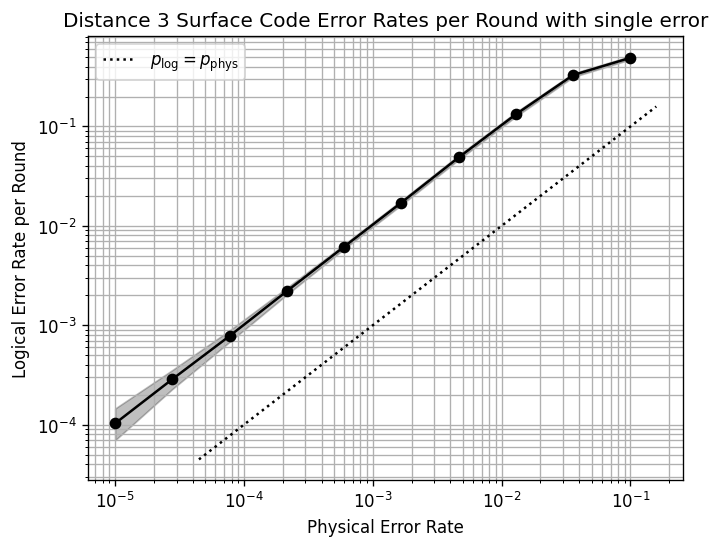

In [331]:
fig,ax = plt.subplots(1,1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Distance 3 Surface Code Error Rates per Round with single error")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [478]:
### using the stim package to graph
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)

# cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)
# print(cirq_circuit)


In [128]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d, 'p': noise},
    )
    for d in [3]
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)

Starting 4 workers...
Done collecting


0 1000000
physical error rate: 1e-05 logical error rate: 0.0 distance: 3
5 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 5e-06 distance: 3
1 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 1e-06 distance: 3
34 1000000
physical error rate: 0.00021544346900318823 logical error rate: 3.4e-05 distance: 3
274 1000000
physical error rate: 0.0005994842503189409 logical error rate: 0.000274 distance: 3
2118 1000000
physical error rate: 0.0016681005372000592 logical error rate: 0.002118 distance: 3
5177 351033
physical error rate: 0.004641588833612777 logical error rate: 0.014747901194474593 distance: 3
5210 57647
physical error rate: 0.012915496650148827 logical error rate: 0.0903776432424931 distance: 3
5147 15132
physical error rate: 0.03593813663804626 logical error rate: 0.3401401004493788 distance: 3
5018 10038
physical error rate: 0.1 logical error rate: 0.4999003785614664 distance: 3


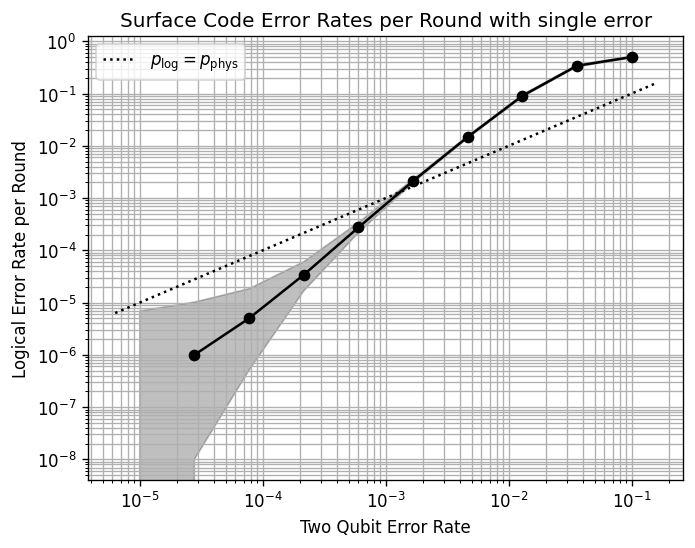

In [129]:
fig,ax = plt.subplots(1,1)

x_func = np.logspace(p_min, p_max, num_points)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Surface Code Error Rates per Round with single error")
ax.set_xlabel("Two Qubit Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [228]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)


print(surface_code_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
RX 1 3 5 8 10 12 15 17 19
Z_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0